# Machine Learning Operations - Data Drift

This notebook was developed by:

- Bruna Simões (20240491)
- Daniel Caridade (20211588)
- Leonardo Di Caterina (20240485)
- Marco Galão (r20201545)

# 1. Libraries Importation

__`Step 1`__ Import the necessary libraries.

In [1]:
import pandas as pd 
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from kneed import KneeLocator
import nannyml as nml
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Helper function from the GitHub repository
# Path of project root
project_root = Path().resolve().parents[1]

# Add the project root directory to Python's module search path
sys.path.append(str(project_root))

# 2. Data Integration 

__`Step 2`__ Importing the dataset into the notebook.

In [3]:
# Load dataset
ref_data = pd.read_csv('../data/02_intermediate/ref_data.csv')
ref_data

cc_num                               merchant  \
0      4561368699336875         fraud_Moen, Reinger and Murphy   
1       213124978348176                      fraud_Block Group   
2        30376238035123        fraud_Brown, Homenick and Lesch   
3       377895991033232                  fraud_Schroeder Group   
4         4198470814557                 fraud_Pfeffer and Sons   
...                 ...                                    ...   
72609  3565423334076143                 fraud_Pfeffer and Sons   
72610     4561546772499                fraud_Bartoletti-Wunsch   
72611  3587960728692500                     fraud_Hudson-Ratke   
72612   377113842678100  fraud_Wuckert, Wintheiser and Friesen   
72613  4179719215697782                    fraud_Hackett Group   

             category     amt     first        last gender  \
0         grocery_pos   94.77    Pamela       Lewis      F   
1            misc_pos    1.52    Steven      Arnold      M   
2      health_fitness  187.25   Cynthia       Davis      F   
3      health_fitness   83.14  Kimberly       Myers      F   
4        shopping_pos    4.48  Christie  Williamson      F   
...               ...     ...       ...         ...    ...   
72609    shopping_pos    2.34    Nathan      Thomas      M   
72610   gas_transport   66.59    Daniel      Briggs      M   
72611     grocery_pos   51.43     Kathy      Hughes      F   
72612            home   10.74     Billy   Gallagher      M   
72613          travel  946.64   Belinda     Jimenez      F   

                               street          city state  ...      long  \
0      653 Jessica Extension Apt. 668       Clifton    SC  ...  -81.8327   
1                    079 Chelsea Rest       Belfast    NY  ...  -78.0943   
2                  7177 Steven Forges         Sixes    OR  ... -124.4409   
3            6881 King Isle Suite 228      Higganum    CT  ...  -72.5751   
4                     519 Jerry Views         Avoca    IA  ...  -95.3509   
...                               ...           ...   ...  ...       ...   
72609   4923 Campbell Pines Suite 717      Carlisle    IN  ...  -87.3667   
72610    7118 Jessica Unions Apt. 789      Moriarty    NM  ... -106.0609   
72611   02110 Lucas Freeway Suite 517  Battle Creek    IA  ...  -95.6045   
72612                673 Delgado Burg     Greenwich    NJ  ...  -75.3209   
72613      6807 Jacob Skyway Apt. 331      Rockwell    IA  ...  -93.2167   

       city_pop                         job                         trans_num  \
0           167  Museum/gallery conservator  b5418bf1297a9a2c7798c072c71f86d7   
1          1766         Mechanical engineer  3c72d3bd4f37d3e6d62d97ee6c834959   
2           217         Retail merchandiser  3c5b0e9241502e52a38e9a4740f2fcae   
3          5438         Librarian, academic  023d6ea0dab88938e4febd03d126dfbe   
4          2036       Engineering geologist  dc0d4e97c86da60ae291428926a61753   
...         ...                         ...                               ...   
72609      4081             Energy engineer  b561c2ac1b825fad9707173d1455bdd2   
72610      7268              Therapist, art  0ce522a6f125020235ac79d10d26c55d   
72611      1075    Teacher, early years/pre  d7eaebf0cee139f3c57c9d639da4b8df   
72612       804     Insurance risk surveyor  631b68a67fa65dcc8a773828c5bc9c79   
72613      1574     Scientist, audiological  69ecc4892f1deb428987888b10fb974c   

       merch_lat  merch_long  is_fraud  merch_zipcode             datetime  \
0      35.471214  -82.229487         0        28746.0  2019-12-13 07:01:46   
1      41.553858  -78.254149         0        15834.0  2020-03-16 00:20:17   
2      42.292880 -123.662784         0        97538.0  2019-08-23 23:04:34   
3      40.943825  -72.006417         0        11954.0  2020-06-15 21:20:24   
4      41.867503  -94.536387         0        50029.0  2019-05-09 15:47:36   
...          ...         ...       ...            ...                  ...   
72609  39.193954  -88.207326         0        6

In [4]:
# Load dataset
ana_data = pd.read_csv('../data/02_intermediate/ana_data.csv')
ana_data

cc_num                          merchant       category  \
0         3596357274378601                   fraud_Doyle Ltd    grocery_pos   
1         6011542681743618             fraud_Leffler-Goldner  personal_care   
2         4099707841315751     fraud_Roberts, Ryan and Smith  personal_care   
3         3595192916105588     fraud_Roob, Conn and Tremblay   shopping_pos   
4         3534718226968689                 fraud_Gerlach Inc   shopping_net   
...                    ...                               ...            ...   
18148       36721445180895             fraud_Friesen-D'Amore  gas_transport   
18149     4607072969078276    fraud_O'Reilly, Mohr and Purdy           home   
18150         567868110212                 fraud_Block Group       misc_pos   
18151      213199865312311  fraud_Monahan, Hermann and Johns         travel   
18152  4560004149983868183    fraud_Kihn, Brakus and Goyette  personal_care   

         amt        first      last gender                           street  \
0      71.68        David   Everett      M                  4138 David Fall   
1      29.17        Emily      Hall      F                  8851 Reese Neck   
2      32.80        James  Stephens      M          1166 Castillo Mountains   
3       3.42       Dustin   Roberts      M               3283 James Station   
4       4.73         Lisa     Lopez      F            32343 Saunders Course   
...      ...          ...       ...    ...                              ...   
18148  71.53        Cesar     Smith      M                 901 Ariel Points   
18149  94.67       Brenda     Perez      F         033 Tara Brook Suite 523   
18150  56.73         Dawn    Tucker      F               789 Herring Manors   
18151   8.39  Christopher    Miller      M  493 Fitzgerald Fields Suite 454   
18152  38.94        Stacy  Villegas      F                 20581 Pena Walks   

                   city state  ...      long  city_pop  \
0            Morrisdale    PA  ...  -78.2357      3688   
1                 Basye    VA  ...  -78.7776       863   
2          Ruckersville    VA  ...  -78.4074      9815   
3          Fayetteville    NC  ...  -79.0080    238602   
4               Dongola    IL  ...  -89.1349      2263   
...                 ...   ...  ...       ...       ...   
18148         Jefferson    NY  ...  -74.6117      1666   
18149             Coyle    OK  ...  -97.2607      1493   
18150           Houston    TX  ...  -95.4034   2906700   
18151           Varnell    GA  ...  -84.9885        74   
18152  Colorado Springs    CO  ... -104.6556    525713   

                                      job                         trans_num  \
0                           Advice worker  f487a7098c0bd4d45f710be1745c4acb   
1                        Engineer, mining  c2ed76f03cce8a6b362729a5a23f01c2   
2              Designer, ceramics/pottery  3c1a5b82410aa0824f7f4aaace067fc8   
3             Scientist, research (maths)  b94caace2f48b8b97a21add8661dca48   
4        Scientific laboratory technician  4b64dbdb7526ac8693b886fb85508d83   
...                                   ...                               ...   
18148             Diagnostic radiographer  f0dac680f0a42fb60e5b3fdf68d38589   
18149              Amenity horticulturist  a943dd7e5ca6cd79c7c39423ad24fa83   
18150             Copywriter, advertising  76aa2ec93f95b8b2a905b4be126f1a87   
18151                 Pensions consultant  69daa2e06268cec48c114ebc24e510e4   
18152  Museum/gallery exhibitions officer  f93f924d08a19064ec37de7a69cf8e4b   

       merch_lat  merch_long  is_fraud  merch_zipcode             datetime  \
0      41.612825  -78.316893         0        15834.0  2019-09-19 07:09:46   
1      39.387521  -79.674956         0        26444.0  2019-02-04 20:37:44   
2      38.705384  -79.152824         0        26802.0  2020-06-05 12:46:32   
3      34.679223  -79.047234         0        28360.0  2019-12-16 22:21:07   
4      37.933436  -88.310510         0        62869.0  2019-12-08 13:29:27   
...     

__`Step 3`__ Creating a list of relevant numeric and categorical features.

In [5]:
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

categorical_features = ['category', 'gender', 'city', 'state', 'zip']

## 3. Data Drift


__`Step 4`__ Create a data drift function and a function to get the optimal number of bins. 

In [6]:
def calculate_psi(expected, actual, buckettype='quantiles', buckets=50, axis=0):
    def scale_range(inp, min_val, max_val):
        inp = inp - np.min(inp)
        inp = inp / (np.max(inp) / (max_val - min_val))
        return inp + min_val

    def psi_unit(exp_arr, act_arr, b):
        bp = np.arange(0, b + 1) / b * 100
        if buckettype == 'bins':
            bp = scale_range(bp, np.min(exp_arr), np.max(exp_arr))
        else:
            bp = np.percentile(exp_arr, bp)
        exp_pct = np.histogram(exp_arr, bp)[0] / len(exp_arr)
        act_pct = np.histogram(act_arr, bp)[0] / len(act_arr)
        def sub(e, a): return (max(e,1e-4) - max(a,1e-4)) * np.log(max(e,1e-4) / max(a,1e-4))
        return sum(sub(e,a) for e,a in zip(exp_pct, act_pct))

    if expected.ndim == 1:
        return np.array([psi_unit(expected, actual, buckets)])
    vals = np.zeros(expected.shape[1] if axis==0 else expected.shape[0])
    for i in range(len(vals)):
        arr_e = expected[:,i] if axis==0 else expected[i,:]
        arr_a = actual[:,i] if axis==0 else actual[i,:]
        vals[i] = psi_unit(arr_e, arr_a, buckets)
    return vals


def find_optimal_bins_with_knee(
    expected_df: pd.DataFrame,
    actual_df: pd.DataFrame,
    bin_range: Tuple[int,int]=(5,50),
    buckettype: str='quantiles'
) -> Tuple[Dict[str,int], Dict[str,pd.DataFrame]]:

    best_bins: Dict[str,int] = {}
    psi_tables: Dict[str,pd.DataFrame] = {}

    for col in expected_df.columns:
        exp = expected_df[col].dropna().values
        act = actual_df[col].dropna().values

        results = []
        for b in range(bin_range[0], bin_range[1]+1):
            psi_val = calculate_psi(exp, act, buckettype=buckettype, buckets=b)[0]
            results.append((b, psi_val))
        
        df = pd.DataFrame(results, columns=['bins','psi'])
        psi_tables[col] = df

        # Knee detection
        kl = KneeLocator(df['bins'], df['psi'], curve='concave', direction='decreasing')
        knee = kl.knee or df.loc[df['psi'].idxmax(), 'bins']
        best_bins[col] = int(knee)

    return best_bins, psi_tables

__`Step 4.1`__ Calculating the optimal number of bins per feature and the PSI values.

In [7]:
optimal_bins_per_feature, _ = find_optimal_bins_with_knee(
    ref_data[numerical_features],
    ana_data[numerical_features],
    buckettype='quantiles'
)

# Initialize a dict to store PSI scores
psi_scores = {}

# Calculate PSI for each feature using its optimal bin count
for feature in numerical_features:
    optimal_bins = optimal_bins_per_feature.get(feature, 10)  # default to 10 if missing
    psi_value = calculate_psi(
        expected=ref_data[feature].values,
        actual=ana_data[feature].values,
        buckettype='quantiles',  # Or 'bins', to match the method used in optimal detection
        buckets=optimal_bins,
        axis=0
    )[0]  # single feature returns an array with one value
    psi_scores[feature] = psi_value

# Convert to Series for display
psi_results = pd.Series(psi_scores)
print("PSI Scores with Optimal Bins:\n", psi_results)

PSI Scores with Optimal Bins:
 amt           0.003626
lat           0.003146
long          0.004897
city_pop      0.004304
merch_lat     0.003643
merch_long    0.004018
dtype: float64


__`Step 4.2`__ Visualizing the PSI values.

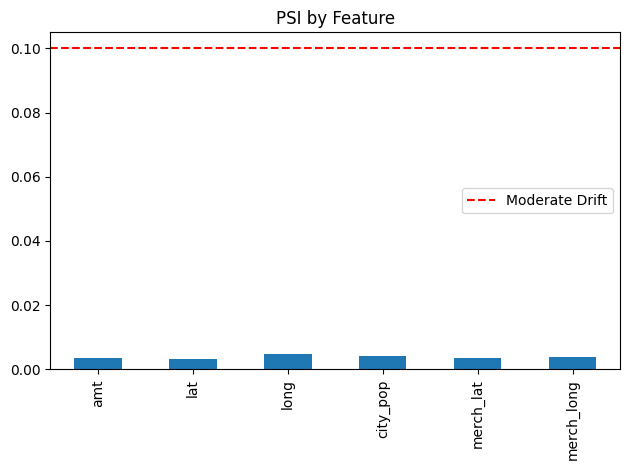

In [8]:
psi_results.plot(kind='bar', title='PSI by Feature')
plt.axhline(0.1, color='red', linestyle='--', label='Moderate Drift')
plt.legend()
plt.tight_layout()
plt.show()

__`Step 5`__ Detecting Univariate Categorical Drift. Running the tests with different chunck sizes to define the number of chunks to use.

In [9]:
chunk_sizes = [100, 200, 360, 500, 1000, 2000, 5000]
results_summary = []
threshold = nml.thresholds.ConstantThreshold(lower=None, upper=0.25)

for chunk in chunk_sizes:
    calc = nml.UnivariateDriftCalculator(
        column_names=categorical_features,
        treat_as_categorical=categorical_features,
        chunk_size=chunk,
        categorical_methods=['jensen_shannon'],
        thresholds={"jensen_shannon": threshold}
    )
    calc.fit(ref_data)
    result = calc.calculate(ana_data)
    
    drift_df = result.filter(period='analysis').to_df()
    
    # Select all columns where level 1 is 'jensen_shannon' and level 2 is 'value'
    js_value_cols = drift_df.loc[:, (slice(None), 'jensen_shannon', 'value')]
    
    # Calculate average Jensen-Shannon value across all features and chunks
    avg_drift = js_value_cols.mean().mean()
    
    num_chunks = drift_df[('chunk', 'chunk', 'chunk_index')].nunique()
    
    results_summary.append({
        "chunk_size": chunk,
        "average_drift_score": avg_drift,
        "num_chunks": num_chunks
    })

summary_df = pd.DataFrame(results_summary)
print(summary_df)

   chunk_size  average_drift_score  num_chunks
0         100             0.440197         182
1         200             0.373332          91
2         360             0.314926          51
3         500             0.283957          37
4        1000             0.220965          19
5        2000             0.173212          10
6        5000             0.100144           4


__`Step 5.1`__ Checking the plot of the average drift score for each chunck size tested, to decide the chunck size.

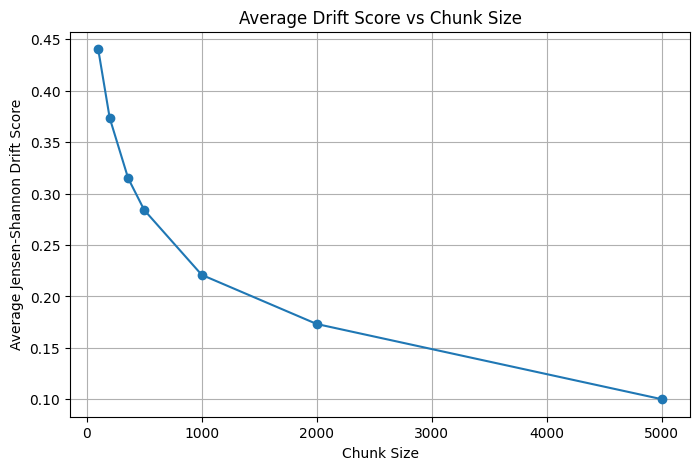

In [10]:
plt.figure(figsize=(8,5))
plt.plot(summary_df['chunk_size'], summary_df['average_drift_score'], marker='o', linestyle='-')
plt.xlabel('Chunk Size')
plt.ylabel('Average Jensen-Shannon Drift Score')
plt.title('Average Drift Score vs Chunk Size')
plt.grid(True)
plt.show()

From the analysis of the graph it seems the elbow is in 1000, so we decided to use 1000 as chunck size.

__`Step 5.2`__ Running the finally analysis of drift using NannyML.

In [11]:
chunk_size = 1000

# Set thresholds
threshold = nml.thresholds.ConstantThreshold(lower=None, upper=0.25)

calc = nml.UnivariateDriftCalculator(
    column_names=categorical_features,
    treat_as_categorical=categorical_features,
    chunk_size=chunk_size,
    categorical_methods=['jensen_shannon'],
    thresholds={"jensen_shannon": threshold}
)

calc.fit(ref_data)
result = calc.calculate(ana_data)
drift_df = result.filter(period='analysis').to_df()

# Save plot
plot = result.filter(period='analysis').plot(kind='drift')
plot.write_html("univariate_drift_nml.html")

__`Step 5.1`__ Printing the final result.

In [12]:
plot

Only the variables related to city and street (locating related present some sort of drift).

__`Step 6`__ Generating Data Drift Report with Evidently

This step uses the Evidently AI library to generate a comprehensive data drift report for numerical features. The report applies statistical tests (Kolmogorov-Smirnov test with a significance level of 0.05) to detect significant shifts in the distributions of the numerical features between the reference and analysis datasets. The results are saved as an interactive HTML report for easy visualization and monitoring.

In [13]:
report = Report(metrics=[
    DataDriftPreset(cat_stattest='ks', stattest_threshold=0.05)])


report.run(
    reference_data=ref_data[numerical_features],
    current_data=ana_data[numerical_features],
    column_mapping=None
)

report.save_html("data_drift_evidently.html")

__`Step 6.1`__ Displaying the results.

In [14]:
report.show()

__`Step 7`__ Creating a different analysis dataset that only has transactions from New York.

In [15]:
ana_data_NY = ana_data[ana_data['state'] == 'NY']

__`Step 7.1`__ Building the report for this new analysis data.

In [16]:
report2 = Report(metrics=[
    DataDriftPreset(cat_stattest='ks', stattest_threshold=0.05)])


report2.run(
    reference_data=ref_data[numerical_features],
    current_data=ana_data_NY[numerical_features],
    column_mapping=None
)

report2.show()

As we can see and as expected in this case the model identifies data drift as it gives us drift detection in 6 out of the 6 tested columns.

__`Step 8`__ Evaluating PSI Stability Across K-Fold Splits of Reference Data

This step applies K-Fold cross-validation on the reference dataset to split it into multiple folds. For each fold, PSI (Population Stability Index) values are calculated between the training fold and the corresponding test fold. This approach helps verify the stability and consistency of PSI scores across different subsets of the reference data, ensuring that detected data drift is robust and not an artifact of a specific sample.

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, _) in enumerate(kf.split(ref_data)):
    ref_fold = ref_data.iloc[train_idx]

    # PSI: comparing each fold of reference data to the under-30 analysis data
    psi_scores = calculate_psi(
        expected=ref_fold[numerical_features].values,
        actual=ana_data[numerical_features].values,
        buckettype='quantiles',
        buckets=10,
        axis=0
    )

    print(f"Fold {i+1} PSI (ref_fold vs. ana_data_under_30):\n", pd.Series(psi_scores, index=numerical_features))

Fold 1 PSI (ref_fold vs. ana_data_under_30):
 amt           0.000529
lat           0.000536
long          0.001300
city_pop      0.000470
merch_lat     0.000728
merch_long    0.000995
dtype: float64
Fold 2 PSI (ref_fold vs. ana_data_under_30):
 amt           0.000581
lat           0.000727
long          0.001311
city_pop      0.000441
merch_lat     0.000615
merch_long    0.000835
dtype: float64
Fold 3 PSI (ref_fold vs. ana_data_under_30):
 amt           0.000304
lat           0.000902
long          0.001460
city_pop      0.000487
merch_lat     0.000660
merch_long    0.001070
dtype: float64
Fold 4 PSI (ref_fold vs. ana_data_under_30):
 amt           0.000402
lat           0.000575
long          0.001195
city_pop      0.000476
merch_lat     0.000604
merch_long    0.001042
dtype: float64
Fold 5 PSI (ref_fold vs. ana_data_under_30):
 amt           0.000451
lat           0.000635
long          0.001209
city_pop      0.000462
merch_lat     0.000730
merch_long    0.000982
dtype: float64


We can't see a significant drift in the full analysis data compared to the reference data.

__`Step 8.2`__ Comparing the PSI values with cross-validation using the dataset with transactions of only New York.

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, _) in enumerate(kf.split(ref_data)):
    ref_fold = ref_data.iloc[train_idx]

    # PSI: comparing each fold of reference data to the under-30 analysis data
    psi_scores = calculate_psi(
        expected=ref_fold[numerical_features].values,
        actual=ana_data_NY[numerical_features].values,
        buckettype='quantiles',
        buckets=10,
        axis=0
    )

    print(f"Fold {i+1} PSI (ref_fold vs. ana_data_NY):\n", pd.Series(psi_scores, index=numerical_features))

Fold 1 PSI (ref_fold vs. ana_data_NY):
 amt           0.013203
lat           4.885086
long          6.086387
city_pop      0.166142
merch_lat     4.140982
merch_long    6.069569
dtype: float64
Fold 2 PSI (ref_fold vs. ana_data_NY):
 amt           0.012759
lat           4.896983
long          6.084348
city_pop      0.166494
merch_lat     4.133051
merch_long    6.067657
dtype: float64
Fold 3 PSI (ref_fold vs. ana_data_NY):
 amt           0.011643
lat           4.889398
long          6.093501
city_pop      0.194160
merch_lat     4.138478
merch_long    6.070879
dtype: float64
Fold 4 PSI (ref_fold vs. ana_data_NY):
 amt           0.012219
lat           4.898365
long          6.090361
city_pop      0.194402
merch_lat     4.137875
merch_long    6.067189
dtype: float64
Fold 5 PSI (ref_fold vs. ana_data_NY):
 amt           0.013613
lat           4.890835
long          6.084931
city_pop      0.193343
merch_lat     4.139754
merch_long    6.061094
dtype: float64


In this case we can know identify the drift across folds.

__`Step 9`__ Detecting Data Drift Using PSI on Principal Component Analysis (PCA) Features.

In this step, numerical features from both reference and analysis datasets are first standardized using StandardScaler. Then, PCA is applied to reduce dimensionality, extracting the top principal components that capture the most variance in the data. PSI is calculated on these PCA-transformed features to identify any drift in the underlying data structure, offering a compact and informative way to monitor changes beyond individual variables.

In [19]:
scaler = StandardScaler()
ref_scaled = scaler.fit_transform(ref_data[numerical_features])
ana_scaled = scaler.transform(ana_data[numerical_features])

pca = PCA(n_components=2)
ref_pca = pca.fit_transform(ref_scaled)
ana_pca = pca.transform(ana_scaled)

# Use PSI on PCA features
psi_pca = calculate_psi(ref_pca, ana_pca)
print("PSI on PCA Components:", psi_pca)

PSI on PCA Components: [0.00291156 0.0045468 ]


No drift detected in PCA components.

__`Step 9.1`__ Detecting Data Drift Using PSI on Principal Component Analysis (PCA) Features using the new york transactions as analysis.

In [20]:
ana_scaled = scaler.transform(ana_data_NY[numerical_features])

pca = PCA(n_components=2)
ref_pca = pca.fit_transform(ref_scaled)
ana_pca = pca.transform(ana_scaled)

# Use PSI on PCA features
psi_pca = calculate_psi(ref_pca, ana_pca)
print("PSI on PCA Components:", psi_pca)

PSI on PCA Components: [2.8452447  5.40774965]


In this case we have strong evidencies of drift in the data. The PCA analysis further supports the presence of drift by showing distinct clusters for reference and analysis data, when we only consider transactions from New York.